In [ ]:
!pip install -r /content/requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 19.1 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=271daf6debd0d4c95d28f46f35c9ea5ff622104a2599a3fa2522e1f6a5db9090
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 421, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 421 (delta 137), reused 130 (delta 123), pack-reused 238
Receiving objects: 100% (421/421), 12.85 MiB | 22.05 MiB/s, done.
Resolving deltas: 100% (215/215), done.


In [ ]:
!pip install -e /content/GroundingDINO

Obtaining file:///content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 15.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Running setup.py develop for groundingdino


In [ ]:
!python /content/download_files.py

Downloaded: sam_vit_h_4b8939.pth
Downloaded: groundingdino_swint_ogc.pth


In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from segment_anything import SamPredictor, sam_model_registry
from diffusers import StableDiffusionInpaintPipeline
from groundingdino.util.inference import load_model, load_image, predict, annotate
from GroundingDINO.groundingdino.util import box_ops
import argparse

In [ ]:
def show_mask(mask, image, random_color=True):
    """
    Overlay a mask on an image and return the composited result.

    Args:
        mask (torch.Tensor): Mask to overlay.
        image (np.ndarray): Image to overlay the mask on.
        random_color (bool, optional): If True, overlay with random color.
                                      If False, use a fixed color. Default is True.

    Returns:
        np.ndarray: Image with the mask overlaid.
    """
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])

    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

def transform_boxes(predictor,boxes, src,device):
    """
    Transform boxes to adjust to the source image dimensions.

    Args:
        boxes (torch.Tensor): Bounding boxes in the format [x_center, y_center, width, height].
        src (np.ndarray): Source image.

    Returns:
        torch.Tensor: Transformed boxes.
    """
    H, W, _ = src.shape
    boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])
    return predictor.transform.apply_boxes_torch(boxes_xyxy, src.shape[:2]).to(device)

def save_image(image, file_path):
    """
    Save an image to the specified file path.

    Args:
        image (PIL.Image.Image): Image to be saved.
        file_path (str): Path where the image will be saved.
    """
    try:
        image.save(file_path)
        print(f"Image saved: {file_path}")
    except Exception as e:
        print(f"Error saving image to {file_path}: {e}")

In [ ]:
def edit_image(path, item, prompt, box_threshold, text_threshold):
    """
    Edit an image by replacing objects using segmentation and inpainting.

    Args:
        path (str): Path to the image file.
        item (str): Object to be recognized in the image.
        prompt (str): Object to replace the selected object in the image.
        box_threshold (float): Threshold for bounding box predictions.
        text_threshold (float): Threshold for text predictions.

    Returns:
        np.ndarray: Edited image.
    """
    src, img = load_image(path)

    # Predict object bounding boxes, logits, and phrases
    boxes, logits, phrases = predict(
        model=groundingdino_model,
        image=img,
        caption=item,
        box_threshold=box_threshold,
        text_threshold=text_threshold
    )

    # Set up predictor
    sam_predictor.set_image(src)
    new_boxes = transform_boxes(sam_predictor,boxes, src,device)

    # Predict masks and annotations
    masks, _, _ = sam_predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=new_boxes,
        multimask_output=False,
    )

    # Overlay mask on annotated image
    img_annotated_mask = show_mask(
        masks[0][0].cpu(),
        annotate(image_source=src, boxes=boxes, logits=logits, phrases=phrases)[...,::-1]
    )

    # Apply inpainting pipeline
    edited_image = pipeline(prompt=prompt,
                        image=Image.fromarray(src).resize((512, 512)),
                        mask_image=Image.fromarray(masks[0][0].cpu().numpy()).resize((512, 512))
    ).images[0]

    return edited_image

In [ ]:
device = "cuda"

# Paths
sam_checkpoint_path = "/content/GroundingDINO/weights/sam_vit_h_4b8939.pth"
groundingdino_model_path = "/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
groundingdino_weights_path = "/content/GroundingDINO/weights/groundingdino_swint_ogc.pth"

# SAM Parameters
model_type = "vit_h"
sam_model = sam_model_registry[model_type](checkpoint=sam_checkpoint_path).to(device=device)
sam_predictor = SamPredictor(sam_model)

# Stable Diffusion
pipeline = StableDiffusionInpaintPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting",
                                                     torch_dtype=torch.float16).to(device)

# Grounding DINO
groundingdino_model = load_model(groundingdino_model_path, groundingdino_weights_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
image_path = "/content/prof_pic.jpg"
looking_for = "shirt"
change_required = "Men's blue t-shirt" #"change the type of shirt the person is wearing from half sleves to full sleves t-shirt"
box_threshold = 0.3
text_threshold = 0.25
output_path = "/content/prof_pic_mod.jpg"

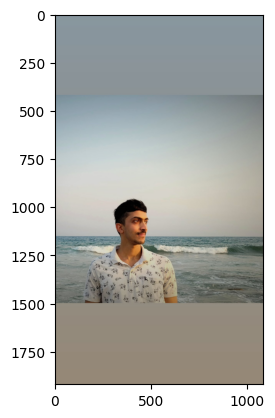

In [ ]:
src, img = load_image(image_path)
plt.imshow(src)

In [ ]:
boxes, logits, phrases = predict(
        model=groundingdino_model,
        image=img,
        caption=looking_for,
        box_threshold=box_threshold,
        text_threshold=text_threshold
    )

In [ ]:
annotated_frame = annotate(image_source=src, boxes=boxes, logits=logits, phrases=phrases)

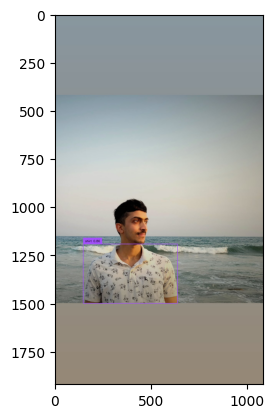

In [ ]:
plt.imshow(np.flip(annotated_frame, 2))

In [ ]:
sam_predictor.set_image(src)
new_boxes = transform_boxes(sam_predictor,boxes, src, device)

masks, _, _ = sam_predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=new_boxes,
    multimask_output=False,
)

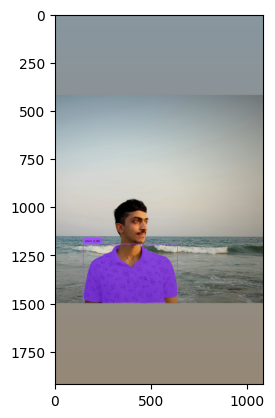

In [ ]:
img_annotated_mask = show_mask(
        masks[0][0].cpu(),
        annotate(image_source=src, boxes=boxes, logits=logits, phrases=phrases)[...,::-1]
    )
plt.imshow(img_annotated_mask)

In [ ]:
edited_image = pipeline(prompt=change_required,
                        image=Image.fromarray(src).resize((512, 512)),
                        mask_image=Image.fromarray(masks[0][0].cpu().numpy()).resize((512, 512))
    ).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

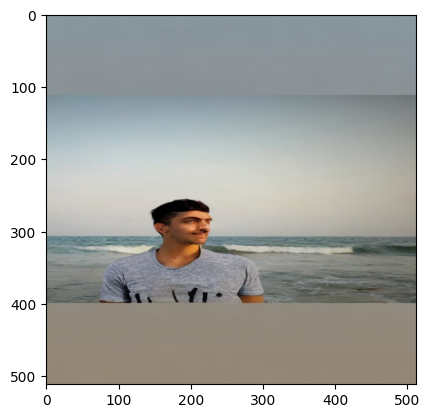

In [ ]:
plt.imshow(edited_image)